In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

from random import randint

import sys
import os
sys.path.append(os.path.abspath('../'))

from crop_and_rescale import crop_and_resize, img_to_binary, crop_symbol

In [2]:
IMG_SIZE = 64

In [3]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)


head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [6]:
batch_size = 512
epochs = 36

In [7]:
class MultiOutputDataGenerator(ImageDataGenerator):
    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [8]:
HEIGHT = 137
WIDTH = 236

5993
5327
502
893
2758
7059
7244
225
1837
4209
1418
5989


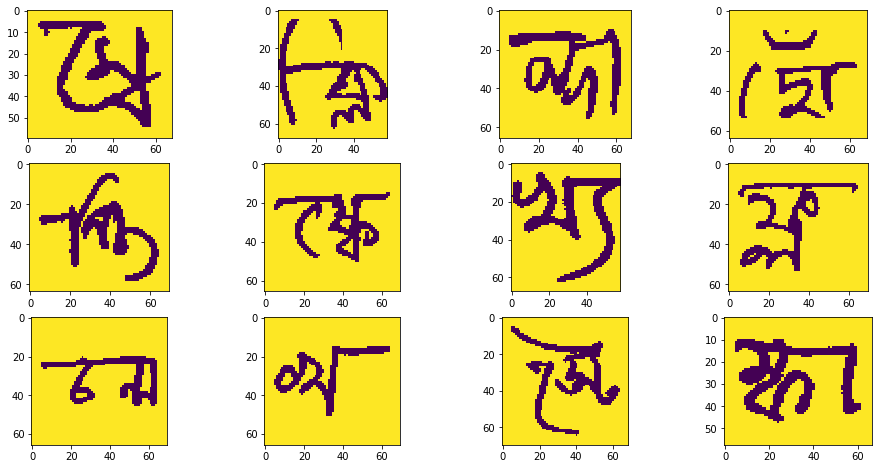

In [11]:
histories = []
train_df_ = pd.read_csv('../data/train.csv')

for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'../parquet/cropped/train_image_data_{i}.parquet'),   
    train_df_, on='image_id').drop(['image_id'], axis=1)

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    for row in ax:
        for col in row:
            rand_int = randint(0, 10000)
            print(rand_int)
            col.imshow(crop_and_resize(train_df.iloc[rand_int,:IMG_SIZE**2]))
    plt.show()
    break

In [25]:
test_df = pd.read_parquet('../parquet/train_image_data_0.parquet')

In [32]:
import numpy as np
resc = np.resize(test_df.iloc[6301, 1:].to_numpy(), (HEIGHT, WIDTH)).astype(int)

In [41]:

horizontal_where = np.any(img == 0, axis=1)
x0 = np.searchsorted(horizontal_where, True)
x1 = x0 + sum(horizontal_where)

vertical_where = np.any(img == 0, axis=0)
y0 = np.searchsorted(vertical_where, True)
y1 = y0 + sum(vertical_where)

img_crop = img[x0:x1, y0:y1]

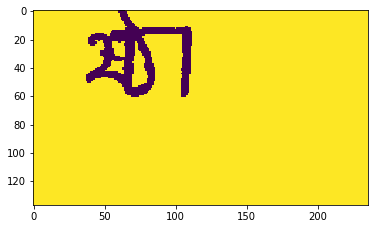

In [45]:
img = img_to_binary(resc)
plt.imshow(img)

/Users/RasmusJust/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  """Entry point for launching an IPython kernel.
/Users/RasmusJust/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  """Entry point for launching an IPython kernel.


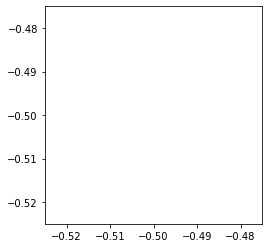

In [42]:
plt.imshow(img_crop)

In [44]:
x0, x1, y0, y1

(137, 198, 236, 311)